In [1]:
# 필요한 라이브러리 호출
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
from tqdm import trange
import os
import random
import time

import cv2
from torch.utils.data import DataLoader, Dataset
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# 이미지 데이터 전처리
class ImageTransform():
    
    def __init__(self, resize, mean, std):
        self.data_transform = {
            # 훈련 이미지 데이터에 대한 전처리
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
            ]),
            # 검증과 테스트 이미지 데이터에 대한 전처리
            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
            ])
        }
    
    def __call__(self, img, phase):
        return self.data_transform[phase](img)

In [3]:
# 변수에 대한 값 정의
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

In [4]:
# 훈련과 테스트 데이터셋 불러오기
cat_directory = r'./data/dogs-vs-cats/Cat/' # r-string을 통해 문자열 내의 백슬래시를 그대로 사용할 수 있다.
dog_directory = r'./data/dogs-vs-cats/Dog/'
test_directory = r'./data/dogs-vs-cats/Test/'

cat_images_filepaths = sorted(os.path.join(cat_directory, f) for f in os.listdir(cat_directory))
dog_images_filepaths = sorted(os.path.join(dog_directory, f) for f in os.listdir(dog_directory))
test_images_filepaths = sorted(os.path.join(test_directory, f) for f in os.listdir(test_directory))

images_filepaths = [*cat_images_filepaths, *dog_images_filepaths]
# 손상파일, 다른 파일 형식, 잘못된 경로 등을 걸러내기 위한 코드
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

random.seed(42)
random.shuffle(correct_images_filepaths)

# 데이터셋을 훈련, 검증, 테스트 용도로 분리
train_images_filepaths = correct_images_filepaths[:20000]
val_images_filepaths = correct_images_filepaths[20000:-10]
test_images_filepaths = [*test_images_filepaths, *correct_images_filepaths[-10:]]

print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

20000 4903 20


In [5]:
# 이미지에 대한 레이블 구분
class DogvsCatDataset(Dataset):

    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list
        # 채널이 3개가 아닌 이미지를 필터링하여 새로운 리스트에 저장
        self.file_list = [f for f in self.file_list if Image.open(f).mode == 'RGB']
        self.transform = transform
        self.phase = phase
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img, self.phase)

        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog':
            label = 1
        elif label == 'cat':
            label = 0
        return img_transformed, label

In [6]:
# 이미지 데이터셋 정의
train_dataset = DogvsCatDataset(train_images_filepaths, transform=ImageTransform(size, mean, std), phase='train')
val_dataset = DogvsCatDataset(val_images_filepaths, transform=ImageTransform(size, mean, std), phase='val')

index = 0
print(train_dataset.__getitem__(index)[0].size())
print(val_dataset.__getitem__(index)[1])

C:\Users\leegyuseok\anaconda3\envs\torch_book\lib\site-packages\PIL\TiffImagePlugin.py:890: UserWarning: Truncated File Read
  warnings.warn(str(msg))


torch.Size([3, 224, 224])
0


In [7]:
# 데이터셋의 데이터를 메모리로 불러오기
train_iterator = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_iterator = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict = {
    'train': train_iterator,
    'val': valid_iterator,
}

batch_iterator = iter(train_iterator)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label)

torch.Size([32, 3, 224, 224])
tensor([1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 1, 1, 0, 0])


In [8]:
# 기본 블록 정의
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=False):
        super().__init__()
        # 3 x 3 합성곱층
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        # 3 x 3 합성곱층
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        if downsample:
            conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)
            bn = nn.BatchNorm2d(out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
        # 다운 샘플링이 필요한 경우, downsample의 값을 객체에 저장
        self.downsample = downsample
    
    def forward(self, x):
        i = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)

        # 다운샘플이 필요한 경우, 원래 입력 i에 다운샘플을 적용
        if self.downsample is not None:
            i = self.downsample(i)
        
        x += i
        x =  self.relu(x)
        
        return x

In [9]:
# 병목 블록 정의
class Bottleneck(nn.Module):
    # ResNet에서 병목 블록을 정의하기 위한 하이퍼파라미터
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, downsample=False):
        super().__init__()
        # 1 x 1 합성곱층
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        # 3 x 3 합성곱층
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        # 1 x 1 합성곱층, 다음 계층 채널 수와 일치하도록 self.expansion x out_channels를 적용
        self.conv3 = nn.Conv2d(out_channels, self.expansion*out_channels, kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*out_channels)
        self.relu = nn.ReLU(inplace=True)

        if downsample:
            conv = nn.Conv2d(in_channels, self.expansion*out_channels, kernel_size=1, stride=stride, bias=False)
            bn = nn.BatchNorm2d(self.expansion*out_channels)
            # 합성곱 레어어와 배치 정규화를 하나의 모듈로 묶어준다.
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
        self.downsample = downsample

    def forward(self, x):
        i = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.downsample is not None:
            i = self.downsample(i)
        
        x += i
        x = self.relu(x)
        return x

In [10]:
# ResNet 모델 네트워크
class ResNet(nn.Module):
    
    def __init__(self, config, output_dim, zero_init_residual=False):
        super().__init__()

        # Resnet을 호출할 때 넘겨준 config 값을 block, n_blocks, channels에 저장
        block, n_blocks, channels = config
        self.in_channels = channels[0]
        # 블록 크기 = 채널 크기 = 4가 아니면 오류 발생
        # ResNet의 표준 구조는 레이어를 4개 사용하기 때문에 이를 강제함
        assert len(n_blocks) == len(channels) == 4
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=7, stride=2, padding=3, bias=False)
        # self.in_channels는 출력 채널 수
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self.get_resnet_layers(block, n_blocks[0], channels[0])
        # ResNet에서 다운 샘플링 시, stride는 2로 한다.
        self.layer2 = self.get_resnet_layers(block, n_blocks[1], channels[1], stride=2)
        self.layer3 = self.get_resnet_layers(block, n_blocks[2], channels[2], stride=2)
        self.layer4 = self.get_resnet_layers(block, n_blocks[3], channels[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(self.in_channels, output_dim)
        
        if zero_init_residual:
            # 모델의 모든 모듈과 서브 모듈(합성곱, 배치 정규화 등을 포함)
            for m in self.modules():
                # 잔차 연결의 초기화를 돕기 위해 배치 정규화 레이어의 가중치를 0으로 초기화
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)
    
    # 블록을 추가하기 위한 함수
    def get_resnet_layers(self, block, n_blocks, channels, stride=1):
        layers = []
        # in_channels와 block.exapnsion * channels가 다르면 dowmsample 적용
        if self.in_channels != block.expansion * channels:
            downsample = True
        else:
            downsample = False

        # 계층을 추가할 때, in_channels, channels, stride 뿐만 아니라 다운 샘플 적용 유무도 함께 전달    
        layers.append(block(self.in_channels, channels, stride, downsample))
        # n_blocks만큼 계층 추가
        for i in range(1, n_blocks):
            layers.append(block(block.expansion*channels, channels))

        self.in_channels = block.expansion * channels
        # 여러 개의 레이어 또는 모듈을 순차적으로 묶어 하나의 모듈로 만드는 데 사용
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x) # 224 x 224
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x) # 112 x 112
        x = self.layer1(x) # 56 x 56
        x = self.layer2(x) # 28 x 28
        x = self.layer3(x) # 14 x 14
        x = self.layer4(x) # 7 x 7
        x = self.avgpool(x) # 1 x 1
        h = x.view(x.shape[0], -1)
        x = self.fc(h)
        return x, h

In [11]:
# ResNetConfig 정의
ResNetConfig = namedtuple('ResNetConfig', ['block', 'n_blocks', 'channels'])

In [12]:
# 기본 블록을 사용하여 ResNetConfig 정의
resnet18_config = ResNetConfig(block=BasicBlock,
                               n_blocks=[2, 2, 2, 2],
                               channels=[64, 128, 256, 512])

resnet34_config = ResNetConfig(block=BasicBlock,
                               n_blocks=[3, 4, 6, 3],
                               channels=[64, 128, 256, 512])
                               

In [13]:
# 병목 블록을 사용하여 ResNetConfig 정의
resnet50_config = ResNetConfig(block=Bottleneck,
                               n_blocks=[3, 4, 6, 3],
                               channels=[64, 128, 256, 512])

resnet101_config = ResNetConfig(block=Bottleneck,
                               n_blocks=[3, 4, 23, 3],
                               channels=[64, 128, 256, 512])

resnet152_config = ResNetConfig(block=Bottleneck,
                               n_blocks=[3, 8, 36, 3],
                               channels=[64, 128, 256, 512])

In [14]:
# 사전 훈련된 ResNet 모델 사용
pretrained_model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

In [15]:
print(pretrained_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [16]:
# ResNet50 Config를 사용한 ResNet 모델 사용
# 2개의 클래스 사용(개와 고양이)
OUTPUT_DIM = 2
model = ResNet(resnet50_config, OUTPUT_DIM)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [17]:
# 옵티마이저와 손실 함수 정의
optimizer = optim.Adam(model.parameters(), lr=1e-7)
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [18]:
# 모델 학습 정확도 측정 함수 정의
def calculate_topk_accuracy(y_pred, y, k=2):
    with torch.no_grad():
        batch_size = y.shape[0]
        # 상위 2개의 예측 값을 가져 옴
        _, top_pred = y_pred.topk(k, 1)
        # k, batch_size 형태로 만듦
        top_pred = top_pred.t()
        # 실제 레이블과 예측값을 동일한 크기로 확장
        correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))
        # 첫 번째 예측값이 맞는지 확인
        correct_1 = correct[:1].reshape(-1).float().sum(0, keepdim=True)
        # 이미지의 정확한 레이블 부여를 위해 사용, 즉, 첫 번째 레이블이 아닌 정확한 레이블 부여를 위해 사용
        # 상위 k개의 예측 값 중 하나라도 맞는지 확인, 예측과 실제 레이블을 요소 별로 비교하기 위해 입/출력 텐서를 같게 유지
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        acc_1 = correct_1 / batch_size
        acc_k = correct_k / batch_size
    return acc_1, acc_k

In [19]:
# 모델 학습 함수 정의
def train(model, iterator, optimizer, criterion, device):
    epoch_loss, epoch_acc_1, epoch_acc_5 = 0, 0, 0
    model.train()
    
    for (x, y) in iterator:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred[0], y)

        acc_1, acc_5 = calculate_topk_accuracy(y_pred[0], y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        # 모델이 첫 번째로 예측한 레이블이 붙여짐
        epoch_acc_1 += acc_1.item()
        # 이미지에 정확한 레이블이 붙여질 것이기 때문에 정확도가 100%이다.
        epoch_acc_5 += acc_5.item()
    
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [20]:
# 모델 평가 함수 정의
def evaluate(model, iterator, criterion, device):
    epoch_loss, epoch_acc_1, epoch_acc_5 = 0, 0, 0
    model.eval()

    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y = y.to(device)
            y_pred = model(x)
            loss = criterion(y_pred[0], y)

            acc_1, acc_5 = calculate_topk_accuracy(y_pred[0], y)
            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()

        epoch_loss /= len(iterator)
        epoch_acc_1 /= len(iterator)
        epoch_acc_5 /= len(iterator)
        return epoch_loss, epoch_acc_1, epoch_acc_5

In [21]:
# 모델 학습 시간 측정 함수 정의
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapse_mins = int(elapsed_time / 60)
    elapse_secs = int(elapsed_time - (elapse_mins * 60))
    return elapse_mins, elapse_secs

In [22]:
# 모델 학습
best_valid_loss = float('inf')
EPOCHS = 10

for epoch in trange(EPOCHS, leave=False):
    start_time = time.monotonic()

    train_loss, train_acc_1, train_acc_5 = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate(model, valid_iterator, criterion, device)

    if best_valid_loss > valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), './data/ResNet-model.pt')
    
    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # 폭을 2자리로 하되, 0으로 2자리를 채워라 1 -> 01
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    # 정확도는 전체 폭을 6으로 한다. '85.12' -> ' 85.12' 
    print(f'\t Train Loss: {train_loss:.3f} | Train Acc: @1: {train_acc_1 * 100:6.2f}% | ' \
          f'Train Acc @5: {train_acc_5 * 100:6.2f}%')
    print(f'\t Valid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1 * 100:6.2f}% | ' \
          f'Valid Acc @5: {valid_acc_5 * 100:6.2f}%')

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]C:\Users\leegyuseok\anaconda3\envs\torch_book\lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
C:\Users\leegyuseok\anaconda3\envs\torch_book\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
 10%|███

Epoch: 01 | Epoch Time: 4m 48s
	 Train Loss: 0.684 | Train Acc: @1:  56.72% | Train Acc @5: 100.00%
	 Valid Loss: 0.681 | Valid Acc @1:  57.32% | Valid Acc @5: 100.00%


 20%|████████████████▍                                                                 | 2/10 [13:59<59:01, 442.64s/it]

Epoch: 02 | Epoch Time: 9m 10s
	 Train Loss: 0.679 | Train Acc: @1:  57.64% | Train Acc @5: 100.00%
	 Valid Loss: 0.676 | Valid Acc @1:  58.57% | Valid Acc @5: 100.00%


 30%|████████████████████████                                                        | 3/10 [29:43<1:18:23, 671.86s/it]

Epoch: 03 | Epoch Time: 15m 44s
	 Train Loss: 0.676 | Train Acc: @1:  58.14% | Train Acc @5: 100.00%
	 Valid Loss: 0.672 | Valid Acc @1:  59.07% | Valid Acc @5: 100.00%


 40%|████████████████████████████████                                                | 4/10 [45:33<1:18:08, 781.42s/it]

Epoch: 04 | Epoch Time: 15m 49s
	 Train Loss: 0.674 | Train Acc: @1:  58.46% | Train Acc @5: 100.00%
	 Valid Loss: 0.669 | Valid Acc @1:  59.74% | Valid Acc @5: 100.00%


 50%|███████████████████████████████████████                                       | 5/10 [1:01:16<1:09:59, 839.93s/it]

Epoch: 05 | Epoch Time: 15m 43s
	 Train Loss: 0.672 | Train Acc: @1:  58.90% | Train Acc @5: 100.00%
	 Valid Loss: 0.667 | Valid Acc @1:  59.83% | Valid Acc @5: 100.00%


 60%|████████████████████████████████████████████████                                | 6/10 [1:17:01<58:22, 875.61s/it]

Epoch: 06 | Epoch Time: 15m 44s
	 Train Loss: 0.671 | Train Acc: @1:  59.05% | Train Acc @5: 100.00%
	 Valid Loss: 0.667 | Valid Acc @1:  59.64% | Valid Acc @5: 100.00%


 70%|████████████████████████████████████████████████████████                        | 7/10 [1:32:50<44:58, 899.44s/it]

Epoch: 07 | Epoch Time: 15m 48s
	 Train Loss: 0.669 | Train Acc: @1:  59.26% | Train Acc @5: 100.00%
	 Valid Loss: 0.664 | Valid Acc @1:  60.98% | Valid Acc @5: 100.00%


 80%|████████████████████████████████████████████████████████████████                | 8/10 [1:48:30<30:24, 912.45s/it]

Epoch: 08 | Epoch Time: 15m 40s
	 Train Loss: 0.668 | Train Acc: @1:  59.43% | Train Acc @5: 100.00%
	 Valid Loss: 0.661 | Valid Acc @1:  61.50% | Valid Acc @5: 100.00%


 90%|████████████████████████████████████████████████████████████████████████        | 9/10 [2:04:16<15:22, 922.95s/it]

Epoch: 09 | Epoch Time: 15m 46s
	 Train Loss: 0.667 | Train Acc: @1:  59.99% | Train Acc @5: 100.00%
	 Valid Loss: 0.662 | Valid Acc @1:  61.29% | Valid Acc @5: 100.00%


Epoch: 10 | Epoch Time: 15m 42s
	 Train Loss: 0.666 | Train Acc: @1:  59.80% | Train Acc @5: 100.00%
	 Valid Loss: 0.660 | Valid Acc @1:  61.72% | Valid Acc @5: 100.00%


In [29]:
# 테스트 데이터셋을 이용한 모델 예측
import pandas as pd
id_list, pred_list = [], []
_id = 0

with torch.no_grad():
    for test_path in test_images_filepaths:
        img = Image.open(test_path)
        _id = test_path.split('/')[-1].split('.')[1]
        transform = ImageTransform(size, mean, std)
        img = transform(img, 'val')
        img = img.unsqueeze(0)
        img = img.to(device)

        model.eval()
        outputs = model(img)
        # [batch_size, num_classes 형태의 텐서로 반환하고, num_classes에 대한 확률 선택]
        preds = F.softmax(outputs[0], dim=1)[:, 1].tolist()
        id_list.append(_id)
        pred_list.append(preds[0])
    
res = pd.DataFrame({
    'id': id_list,
    'label': pred_list,
})

# res.sort_values(by='id', inplace=True)
res.reset_index(drop=True, inplace=True)

res.to_csv('./data/ResNet.csv', index=False)
res.head(20)

,id,label
0,Anbong,0.466242
1,BigMouth,0.404907
2,H2,0.518312
3,Haaksong,0.362624
4,HentaiShim,0.602045
5,JaJiHo,0.661376
6,Librarian,0.458860
7,Linder,0.545362
8,Pychopath,0.450896
9,Stranger,0.699197


./data/dogs-vs-cats/Test/test.Anbong.jpg
Anbong
./data/dogs-vs-cats/Test/test.BigMouth.jpg
BigMouth
./data/dogs-vs-cats/Test/test.H2.jpg
H2
./data/dogs-vs-cats/Test/test.Haaksong.jpg
Haaksong
./data/dogs-vs-cats/Test/test.HentaiShim.jpg
HentaiShim
./data/dogs-vs-cats/Test/test.JaJiHo.jpg
JaJiHo
./data/dogs-vs-cats/Test/test.Librarian.jpg
Librarian
./data/dogs-vs-cats/Test/test.Linder.jpg
Linder
./data/dogs-vs-cats/Test/test.Pychopath.jpg
Pychopath
./data/dogs-vs-cats/Test/test.Stranger.jpg
Stranger
./data/dogs-vs-cats/Cat/cat.1869.jpg
1869
./data/dogs-vs-cats/Dog/dog.9518.jpg
9518
./data/dogs-vs-cats/Cat/cat.3031.jpg
3031
./data/dogs-vs-cats/Cat/cat.5527.jpg
5527
./data/dogs-vs-cats/Cat/cat.6173.jpg
6173
./data/dogs-vs-cats/Cat/cat.7073.jpg
7073
./data/dogs-vs-cats/Dog/dog.967.jpg
967
./data/dogs-vs-cats/Cat/cat.10749.jpg
10749
./data/dogs-vs-cats/Cat/cat.2159.jpg
2159
./data/dogs-vs-cats/Dog/dog.6610.jpg
6610


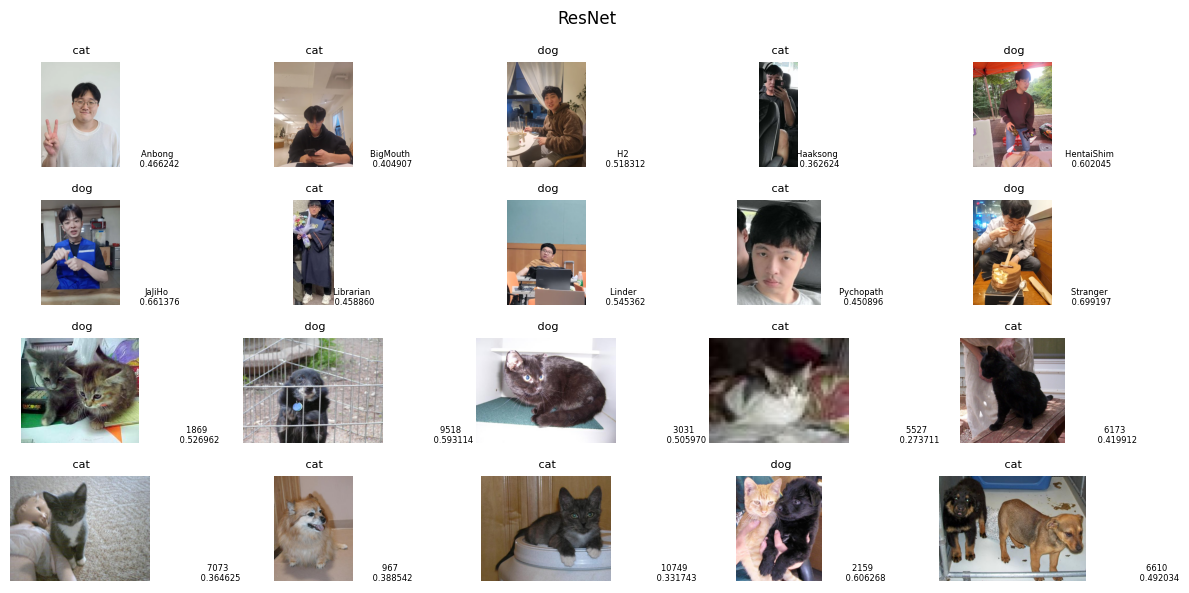

In [31]:
# 모델 예측에 대한 결과 출력

class_ = classes = {0: 'cat', 1: 'dog'}

def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    figure.suptitle('ResNet')
    for i, images_filepath in enumerate(images_filepaths):
        image = cv2.imread(images_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        id = res.loc[i, 'id']
        label = res.loc[i, 'label']
        # 원래 저장된 label을 보존
        _original_label = label

        if label > 0.5:
            label = 1
        else:
            label = 0
        
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(f' {class_[label]}', fontsize=8)
        ax.ravel()[i].text(1.5, 0, f'{id} \n {_original_label:.6f}', fontsize=6, ha='center', transform=ax.ravel()[i].transAxes)
        ax.ravel()[i].set_axis_off()

    plt.tight_layout()
    plt.show()

display_image_grid(test_images_filepaths)